In [1]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt

In [16]:
score_path = '../results/'
df_scores = pd.read_csv(score_path+'1_3_dat_unique_item.csv')
df_td = df_scores.drop_duplicates(subset='ResponseId', keep='first')
df_agency = pd.read_csv(score_path+'agency_scores.csv')
df_gainloss = pd.read_csv(score_path+'dat_lossgain_scores.csv')
# df_td = pd.read_csv(score_path+'td_scores.csv')
print(len(df_td), len(df_agency), len(df_gainloss)) ## align with R results
### use inner join to merge the dataframes

1349 1344 1348


In [10]:
df_td.columns[0] ### the key to join scores

'ResponseId'

In [17]:
# Add up all columns ending with '_avail' and '_realistic', ignoring NA
avail_sum = df_agency.filter(like='_avail').sum(axis=1, skipna=True)
realistic_sum = df_agency.filter(like='_realistic').sum(axis=1, skipna=True)

# Adding the sums as new columns to the dataframe
df_agency['total_avail'] = avail_sum
df_agency['total_realistic'] = realistic_sum
df_agency['num_items'] = df_agency.apply(lambda row: row[1:19].notna().sum(), axis=1)

In [18]:
df_agency['num_items'].unique()

array([16, 14, 18])

In [19]:
print('item=14', sum(df_agency['num_items'] == 14))
print('item=16', sum(df_agency['num_items'] == 16))
print('item=18', sum(df_agency['num_items'] == 18))
#### most of them answered 16 items and then we used 16 items for rescaling
df_agency['rescale_avail'] = df_agency['total_avail'] / (df_agency['num_items'] / 2) * 8
df_agency['rescale_realistic'] = df_agency['total_realistic'] / (df_agency['num_items'] / 2) * 8
df_agency['agency'] = df_agency['rescale_avail'] + df_agency['rescale_realistic']

item=14 392
item=16 733
item=18 219


In [20]:
df_td_select = df_td[['ResponseId', 'zipcode', 'alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss']]
df_scores = pd.merge(df_td_select,df_gainloss,on='ResponseId',how='inner')
# df_agency_selected = df_agency[['ResponseId', 'total_avail',
#        'total_realistic', 'num_items', 'rescale_avail', 'rescale_realistic','agency',]]
df_agency_selected = df_agency[['ResponseId', 'total_avail',
       'total_realistic', 'num_items', 'rescale_avail', 'rescale_realistic','agency','agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail']]
df_merged_scores = df_scores.merge(df_agency_selected,on='ResponseId',how='inner')

In [21]:
def scale_to_100(x, min_val, max_val):
    """
    Scale a given value x from its original range [min_val, max_val] to [0, 100].
    
    Parameters:
    - x: The value to scale.
    - min_val: The minimum value of the original range.
    - max_val: The maximum value of the original range.
    
    Returns:
    - The scaled value in the range [0, 100].
    """
    return (x - min_val) * 100 / (max_val - min_val)

In [22]:
### this depends on the number of items in each type of socres
min_agency, max_agency = -32, 32  
min_td, max_td = 0, 16   
min_loss, max_loss = 0, 6 

In [23]:
regulated_agency = scale_to_100(df_merged_scores['agency'], min_agency, max_agency)
regulated_scores = scale_to_100(df_merged_scores['score'], min_td, max_td)
regulated_loss = scale_to_100(df_merged_scores['loss_aversion_scores'], min_loss, max_loss) 

In [24]:
df_merged_scores['regulated_agency'] = regulated_agency
df_merged_scores['regulated_scores'] = regulated_scores
df_merged_scores['regulated_loss'] = regulated_loss

### Zscores

In [52]:
from scipy.stats import zscore
df_merged_scores['agency_z'] = zscore(df_merged_scores['agency'])
df_merged_scores['scores_z'] = zscore(df_merged_scores['score'])
df_merged_scores['loss_z'] = zscore(df_merged_scores['loss_aversion_scores'])

(array([ 16.,   0.,   0.,  41.,   0.,   0., 116.,   0.,   0.,   0., 371.,
          0.,   0., 231.,   0.,   0., 182.,   0.,   0., 101.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <BarContainer object of 20 artists>)

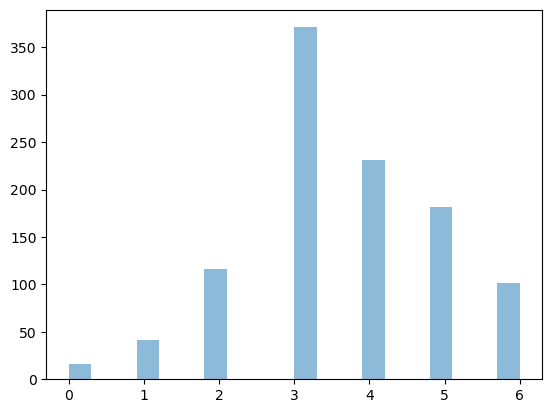

In [60]:

plt.hist(df_merged_scores['loss_aversion_scores'], bins=20, alpha=0.5, label='agency')

(array([ 16.,   0.,   0.,  41.,   0.,   0., 116.,   0.,   0.,   0., 371.,
          0.,   0., 231.,   0.,   0., 182.,   0.,   0., 101.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

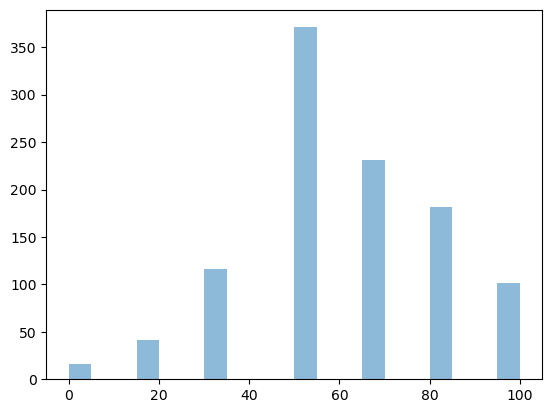

In [61]:
plt.hist(df_merged_scores['regulated_loss'], bins=20, alpha=0.5, label='agency')

(array([ 16.,   0.,   0.,  41.,   0.,   0., 116.,   0.,   0.,   0., 371.,
          0.,   0., 231.,   0.,   0., 182.,   0.,   0., 101.]),
 array([-2.70550418, -2.48105906, -2.25661394, -2.03216882, -1.8077237 ,
        -1.58327858, -1.35883346, -1.13438834, -0.90994322, -0.68549811,
        -0.46105299, -0.23660787, -0.01216275,  0.21228237,  0.43672749,
         0.66117261,  0.88561773,  1.11006285,  1.33450797,  1.55895309,
         1.78339821]),
 <BarContainer object of 20 artists>)

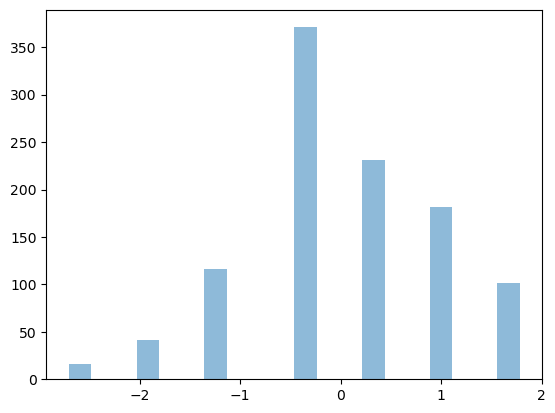

In [62]:
plt.hist(df_merged_scores['loss_z'], bins=20, alpha=0.5, label='agency')

### add other columns of the survey

In [8]:
### can be used in the future
df_survey = pd.read_csv('person_info.csv')

In [9]:
df_survey_select = df_survey[['ResponseId','expectation_num',
 'internet_num',
 'financial_2020_num',
 'financial_now_num',
 'financial_change_num',
 'credit_debt_num',
 'gender_num',
 'education_num',
 'employment_num',
 'race_num','destination']]

In [10]:
df_all_survey_num = df_merged_scores.merge(df_survey_select,on='ResponseId',how='left')

In [11]:
df_all_survey_num.to_csv('survey_scores_perinfo_v2.csv')
# df_all_survey_num.to_csv('survey_scores_perinfo.csv')

In [52]:
df_all_survey_num

Index(['ResponseId', 'zipcode', 'alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss', 'loss_gain_1', 'loss_loss_1', 'loss_gain_2',
       'loss_loss_2', 'loss_gain_3', 'loss_loss_3', 'mask_march2020',
       'mask_spring2020', 'mask_summer2020', 'mask_fall2020',
       'mask_winter2020', 'indoor_march2020', 'indoor_spring2020',
       'indoor_summer2020', 'indoor_fall2020', 'indoor_winter2020',
       'gain_bias', 'loss_bias', 'loss_aversion_scores', 'mask_march2020_num',
       'mask_spring2020_num', 'mask_summer2020_num', 'mask_fall2020_num',
       'mask_winter2020_num', 'indoor_march2020_num', 'indoor_spring2020_num',
       'indoor_summer2020_num', 'indoor_fall2020_num', 'indoor_winter2020_num',
       'mask_march2020_num_avg', 'mask_spring2020_num_avg',
       'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg', 'indoor_march2020_num_avg',
       'indoor_spri

In [12]:
# df = pd.read_csv('survey_scores_perinfo.csv')
df = pd.read_csv('survey_scores_perinfo_v2.csv')

(array([  4.,   4.,   2.,   9.,   0.,  21.,  37.,  56.,  74.,   0.,  75.,
         84., 117., 268.,   0.,  53.,  79.,  46.,  40.,  89.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. ]),
 <BarContainer object of 20 artists>)

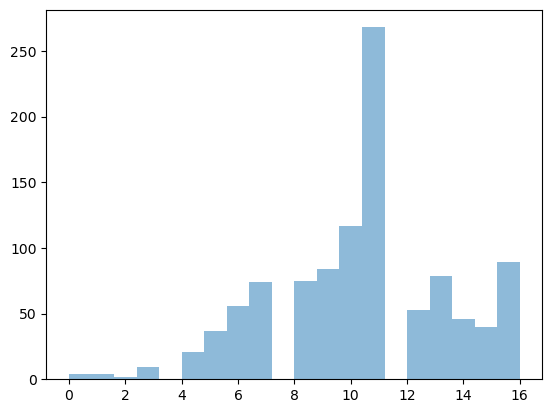

In [3]:
plt.hist(df['score'], bins=20, alpha=0.5, label='score')

### check the correlations

In [61]:
# Assuming 'selected_columns' is your DataFrame with selected columns
correlation_matrix = df_all_survey_num[['alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'Age', 'Risk_preference', 'score', 'presbias',
       'absolmag', 'gainloss', 'mask_march2020_num_avg', 'mask_spring2020_num_avg',
       'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg', 'indoor_march2020_num_avg',
       'indoor_spring2020_num_avg', 'indoor_summer2020_num_avg',
       'indoor_fall2020_num_avg', 'indoor_winter2020_num_avg',
        'loss_aversion_scores', 'rescale_avail', 'rescale_realistic',
          'expectation_num', 'internet_num',
       'financial_2020_num',  'financial_change_num',
       'credit_debt_num', 'gender_num', 'education_num', 'employment_num',
       'race_num']].corr()

In [13]:
import matplotlib.pyplot as plt

<Figure size 6750x9000 with 0 Axes>

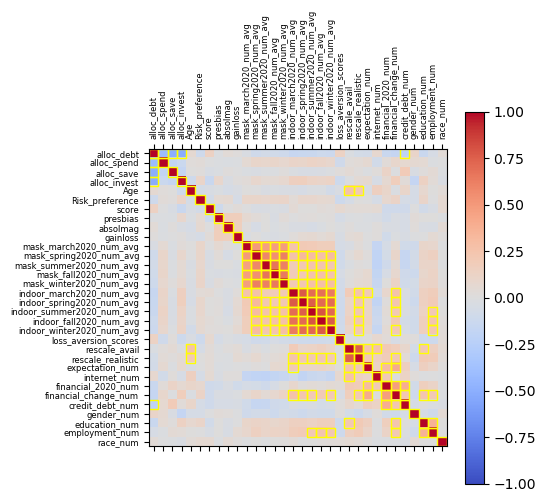

In [89]:

plt.figure(figsize=(15, 20),dpi=450)  # Adjust the figure size as needed
cax = plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Highlight cells with absolute value greater than 0.5
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.2:
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='yellow', lw=1))

plt.colorbar(cax)

# Adding axis labels with column names for clarity
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90,size=6)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns,size=6)

# Optional: Add a title
# plt.title('Correlation Matrix Heatmap', y=1.15)

# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show(dpi=450)
plt.savefig('individual_correlation.jpg',dpi=400,bbox_inches='tight')

### check asymmetric of agency scores

In [77]:
df_zipcodes_counts = pd.DataFrame(df_merged_scores.groupby('zipcode')['zipcode'].count())
df_zipcodes_counts.rename(columns={'zipcode':'counts'},inplace=True)
condition = (df_merged_scores['agency_uber_avail'] > df_merged_scores['agency_uber_realistic']) | (df_merged_scores['agency_delivery_avail'] > df_merged_scores['agency_delivery_realistic'])
filtered_df = df_merged_scores[condition]
df_zipcodes_counts['avail_gr_real'] = filtered_df.groupby('zipcode')['zipcode'].count()
condition = (df_merged_scores['agency_uber_avail'] != df_merged_scores['agency_uber_realistic']) | (df_merged_scores['agency_delivery_avail'] != df_merged_scores['agency_delivery_realistic'])
filtered_df = df_merged_scores[condition]
df_zipcodes_counts['avail_nq_real'] = filtered_df.groupby('zipcode')['zipcode'].count()

In [79]:
df_zipcodes_counts['avail_gr_per'] = df_zipcodes_counts['avail_gr_real']/df_zipcodes_counts['counts']

In [83]:
df_zipcodes_counts.to_csv('asymmetric_agency_zipcodes.csv')
df_merged_scores.to_csv('actions_scores_indiviudal.csv',index=False)

### unpivot to individual level

In [ ]:
selected_columns = ['Age', 'Risk_preference', 'score', 'gain_bias', 'loss_bias', 
                    'loss_aversion_scores', 'rescale_avail', 'rescale_realistic','agency','alloc_debt', 'alloc_spend', 'alloc_save',
       'alloc_invest', 'mask_march2020_num_avg',
       'mask_spring2020_num_avg', 'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg', 'indoor_march2020_num_avg', 'indoor_spring2020_num_avg',
       'indoor_summer2020_num_avg', 'indoor_fall2020_num_avg', 'indoor_winter2020_num_avg','zipcode']

In [ ]:
mask_cols = ['mask_march2020_num_avg',
       'mask_spring2020_num_avg', 'mask_summer2020_num_avg', 'mask_fall2020_num_avg',
       'mask_winter2020_num_avg']
melted_df_mask = pd.melt(df_merged_scores, id_vars=['Age',
       'Risk_preference', 'score', 'gain_bias', 'loss_bias', 'rescale_avail',
       'rescale_realistic'], value_vars = mask_cols, 
                    var_name ='period', value_name ='behaviour_mask')
# Correctly adjust the code to perform the intended replacement
# melted_df_mask['week'] = melted_df['week'].apply(lambda x: (int(x.split('_')[1]) - 3))

In [ ]:
melted_df_mask

### aggrated to zipcode level

In [25]:
selected_columns = ['score', 'gain_bias', 'loss_bias', 
                    'loss_aversion_scores', 'rescale_avail', 'rescale_realistic','agency',
                    'regulated_scores','regulated_agency','regulated_loss']

count    1058.000000
mean       10.362004
std         3.213081
min         0.000000
25%         8.000000
50%        11.000000
75%        12.000000
max        16.000000
Name: score, dtype: float64


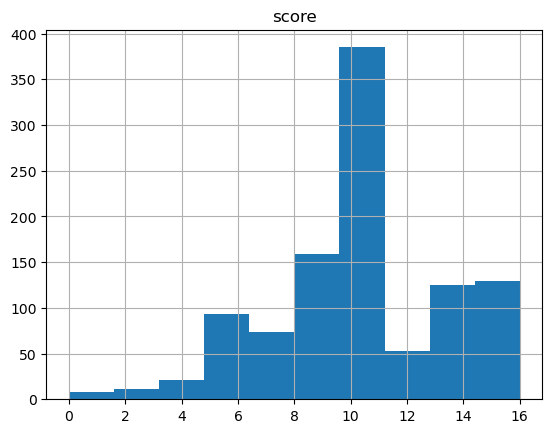

count    1058.000000
mean        1.938563
std         0.971206
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: gain_bias, dtype: float64


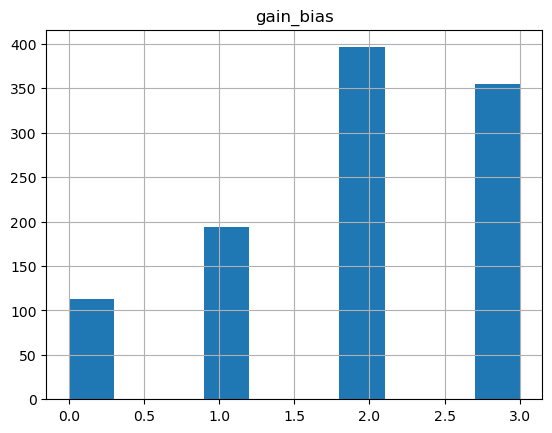

count    1058.000000
mean        1.677694
std         1.060646
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: loss_bias, dtype: float64


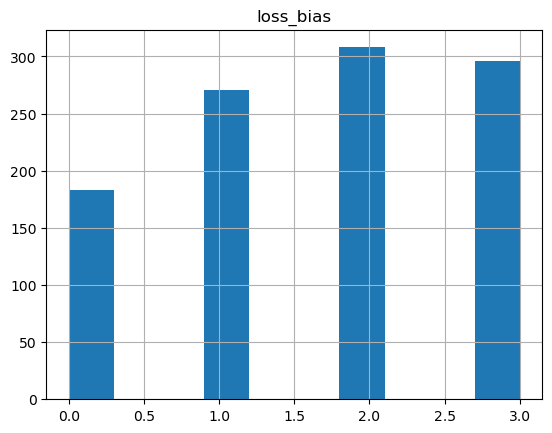

count    1058.000000
mean        3.616257
std         1.337262
min         0.000000
25%         3.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: loss_aversion_scores, dtype: float64


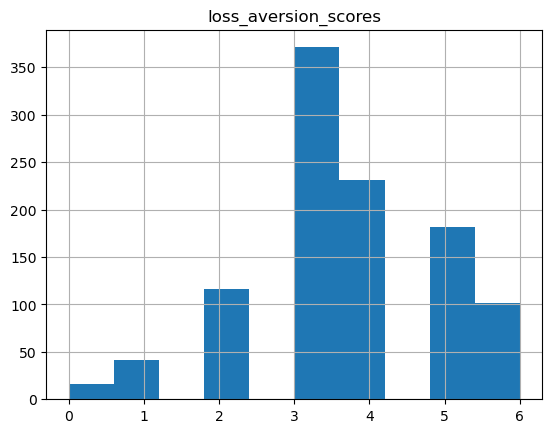

count    1058.000000
mean        6.214571
std         6.183528
min       -16.000000
25%         3.000000
50%         7.000000
75%        10.285714
max        16.000000
Name: rescale_avail, dtype: float64


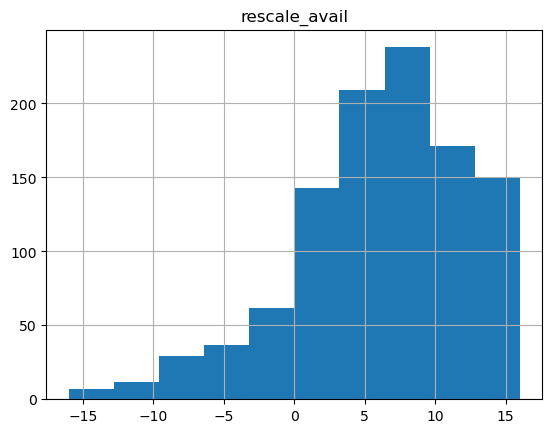

count    1058.000000
mean        5.055571
std         6.136458
min       -16.000000
25%         1.000000
50%         6.000000
75%         9.000000
max        16.000000
Name: rescale_realistic, dtype: float64


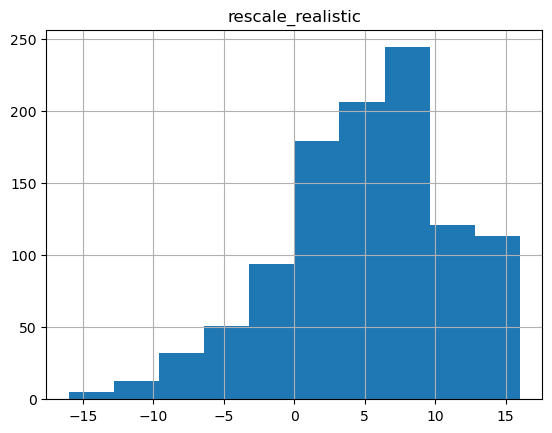

count    1058.000000
mean       11.270141
std        11.543283
min       -32.000000
25%         4.000000
50%        12.444444
75%        19.428571
max        32.000000
Name: agency, dtype: float64


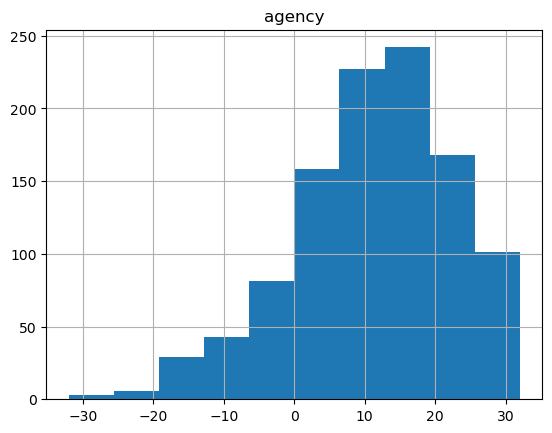

count    1058.000000
mean       64.762524
std        20.081757
min         0.000000
25%        50.000000
50%        68.750000
75%        75.000000
max       100.000000
Name: regulated_scores, dtype: float64


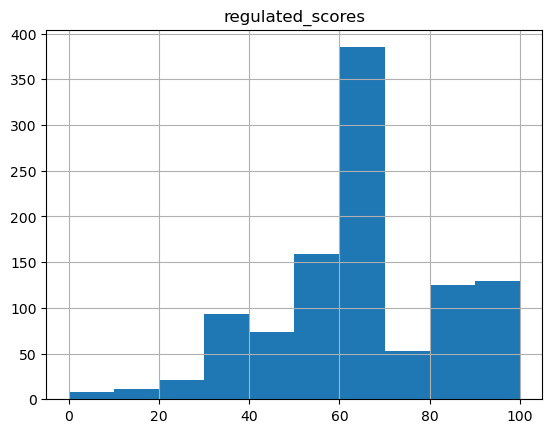

count    1058.000000
mean       67.609596
std        18.036379
min         0.000000
25%        56.250000
50%        69.444444
75%        80.357143
max       100.000000
Name: regulated_agency, dtype: float64


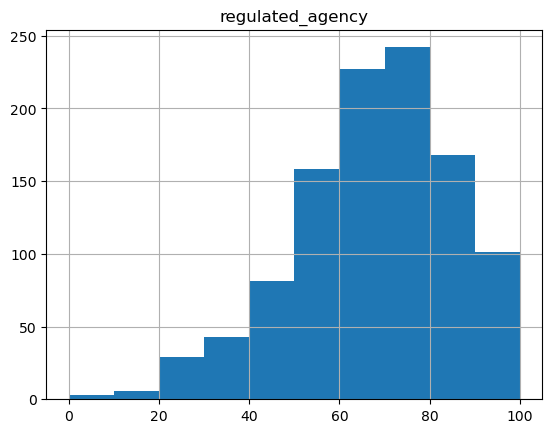

count    1058.000000
mean       60.270951
std        22.287696
min         0.000000
25%        50.000000
50%        50.000000
75%        83.333333
max       100.000000
Name: regulated_loss, dtype: float64


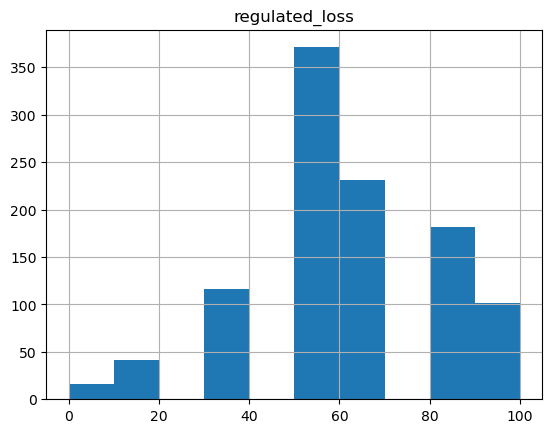

In [65]:
for col in selected_columns:
    print(df_merged_scores[col].describe())
    ax = df_merged_scores[col].hist()
    ax.set_title('{}'.format(col))
    plt.show()
    plt.close()

In [ ]:
from matplotlib import colors

corr = df_merged_scores[selected_columns].corr()
fig, ax = plt.subplots(figsize=(15, 15))  # Optional: specifies the figure size
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

cax = ax.matshow(corr, cmap='coolwarm',norm=norm)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

# Add a color bar
fig.colorbar(cax)

# Optional: Add annotations with the correlation values
for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

plt.title("Correlation Matrix Heatmap", pad=20)
plt.show()

In [26]:
aggregations = {col: ['mean', 'median', 'std'] for col in selected_columns}
df_aggregated = df_merged_scores.groupby('zipcode').agg(aggregations)
df_aggregated.reset_index(inplace=True)
df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]
df_aggregated.rename(columns={'zipcode_':'zipcode'},inplace=True)

In [27]:
df_aggregated.to_csv(score_path+'zipcode_scores_v2.csv',index=False)